In [43]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import display, HTML
from transformers import DistilBertModel, DistilBertTokenizer, logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm as tqdm_notebook
import seaborn as sns
import pandas as pd
import numpy as np
import collections
from collections import Counter
import glob
import pickle
import random
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
import sys
from sklearn.preprocessing import LabelBinarizer

In [2]:
logging.set_verbosity_error()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')

In [3]:
# Own Functions
from build_features import similarity_matrix as vector_values
from predict_model import load_CUB_Bert, load_simBERT, loadBERT
from predict_model import SpanPredictor as classify

In [4]:
output = 233

In [5]:
model = load_CUB_Bert("../models/", 'saved_weights_SPECIES_PLANT_233.pt', outputsize=output)

Local Success


In [6]:
POWO = pickle.load(open('../data/processed/RDF_text_POWOSET.pkl', 'rb'))
TEST = pickle.load(open('../data/processed/RDF_text_TESTSET.pkl', 'rb'))

In [7]:
lb = LabelBinarizer()
keys = np.array([key for key in POWO.keys()])
keys_encoded = lb.fit_transform(keys)

In [55]:
def WhichPlant(span, model):

    """
    Uses a trained bert classifier to see if a span
    belongs to a species description or otherwise.
    """
        
    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(span, return_tensors="pt", truncation='only_first', )
        # Predict class
        outputs = model(**inputs)
        # Get prediction values
        exps = torch.exp(outputs)
        # Get class
        probs = exps.detach().numpy()
        
        #return np.squeeze(probs)
        
        # TESTING
        outputs = outputs.detach().numpy()
        return np.squeeze(outputs)

In [56]:
#WhichPlant('this is a test ', model=model)

In [57]:
plant_idx = 111
species = list(POWO.keys())
plant = species[plant_idx]
print('NAME:', plant)

NAME: Areca catechu


In [58]:
#plant = list(data.keys())[1]
print(plant)

probs_stack = np.empty((0, output), float)
text_span = ''

for text in tqdm_notebook(TEST[plant][0:]):
    #text_span += f'{text} ' 
    #probs = WhichPlant(text_span, model=model)
    probs = WhichPlant(text, model=model)
    probs_stack = np.vstack((probs_stack, probs))

Areca catechu


  0%|          | 0/63 [00:00<?, ?it/s]

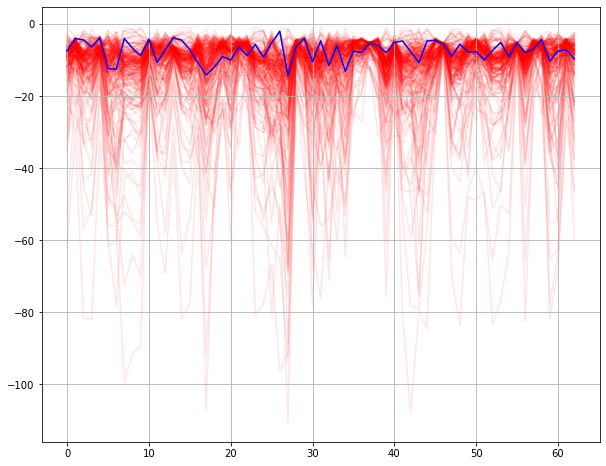

In [59]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(0, output):
    if i == np.where(lb.classes_ == plant)[0][0]:
        ax.plot(probs_stack[:, i], color='blue', alpha=1, markersize=5, zorder=2)
    else:
        
        ax.plot(probs_stack[:, i], color='red', alpha=0.1, zorder=1)
plt.grid()

In [60]:
correct =  probs_stack[:, i]
uncorrect = np.delete(probs_stack, i, axis=1)

In [61]:
#uncorrect[0]

In [74]:
correct     = []
not_correct = []

for plant in tqdm_notebook(species[0:40]):
    # Index plant
    idx = np.where(lb.classes_ == plant)[0][0]
    for text in TEST[plant]:
        probabilities = WhichPlant(text, model=model)
        correct.append(probabilities[idx])
        not_correct += list(np.delete(probabilities, idx))

  0%|          | 0/40 [00:00<?, ?it/s]

In [75]:
correct = np.array(correct)

In [76]:
not_correct = np.array(not_correct)

In [77]:
stats.levene(correct, not_correct)

LeveneResult(statistic=29.12647059071801, pvalue=6.78362607589341e-08)

In [78]:
stats.ttest_ind(correct, not_correct, alternative='greater', equal_var=False)

Ttest_indResult(statistic=13.69033806307626, pvalue=3.269213050198372e-41)

In [79]:
d = {'Yes': correct, 'No': not_correct}
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))

In [80]:
df_m = df.melt()

<AxesSubplot:xlabel='variable', ylabel='value'>

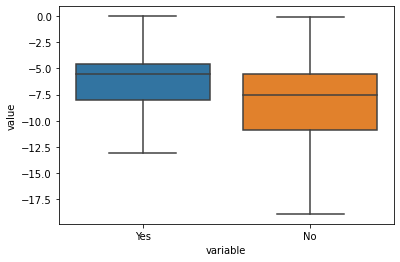

In [81]:
sns.boxplot(x="variable", y="value", data=df_m, showfliers=False)

In [ ]:
#pos_array = np.array(data[plant][0:])
#idx = np.where(lb.classes_ == plant)[0][0]
#pos_array[probs_stack[:, idx] > .9]

In [ ]:

data_plants = collections.defaultdict(list)
data_plants_all = collections.defaultdict(list)

for plant in tqdm_notebook(species[0:]):
    
    for text in TEST[plant]:
    #for row in important_stuff:
        #text_span += f' {row}.' 
        probabilities_stacked = WhichPlant(text, model=model)
        
        idx = np.where(lb.classes_ == plant)[0][0]
        data_plants[plant].append(probabilities_stacked[idx])

In [ ]:
len(data_plants_all['Boswellia sacra'])

In [ ]:
pred_correct   = []
pred_uncorrect = []

for plant in species[0:1]:
    for values in data_plants_all[plant]:
        values

In [ ]:
idx = np.where(lb.classes_ == plant)[0][0]

In [ ]:
values.shape

In [ ]:
total = []
for plant in species:
    total += data_plants[plant]
    
total = np.array(total)

In [ ]:
sns.displot(total[total < 0.4], kind="ecdf")

In [ ]:

fig, ax = plt.subplots(figsize=(10, 8))

for plant in species:
    ax.plot(data_plants[plant], alpha=0.3, color='blue')
plt.grid()
#plt.legend()
plt.show()



In [ ]:
def check_values(sents):
    
    count = 0
    # Check other combinations
    for species in data.keys():
        length = len(set(sents).intersection(data[species]))
        if length == len(sents):
            count += 1
        
    return count

In [ ]:
text_list = []
pred_sing = []
pred_mult = []
single_other = []
multip_other = []

for idx, (row, value) in enumerate(tqdm_notebook(plant_list[0:])):
    text_list.append(row)
    pred_sing.append(output / value / output)
    if idx != 0 and pred_mult[-1] == 1:
        pred_mult.append(1)
    else:
        pred_mult.append(output / check_values(text_list) / output)
            

In [ ]:
pred_sing = []
pred_all_single = np.zeros(shape=(len(plant_list[0:]), output))

for idx, (row, value) in enumerate(tqdm_notebook(plant_list[0:])):
    temp_s = []
    for x in data.keys():
        if row in data[x]:
            temp_s.append(output / value / output)
        else:
            temp_s.append(0)
    pred_all_single[idx] = temp_s


In [ ]:
#len(species)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(0, output):
    if i == plant_idx:
        ax.plot(pred_all_single[:, i], color='blue', alpha=1, markersize=5, zorder=2, )
    else:
        ax.plot(pred_all_single[:, i], color='red', alpha=0.05, zorder=1,)
plt.plot(pred_mult, color='orange')
plt.grid()

In [ ]:
text_list[0:np.array(pred_mult).argmax()]